# Deep Dream GoogLeNet

Deep Dream Algorithm understanding using PyTorch's pretrained GoogLeNet.

### DISCLAIMER:

This algorithm is not mine, nor it is my idea. This is my own implementation using PyTorch and it has been done with the goal of understanding different PyTorch concepts.

In [1]:
%%capture

# whithout scipy==1.3.3 Inceptionv3 takes too long to load
!pip install --upgrade scipy==1.3.3

In [2]:
import glob

import torch
import torchvision
from torchvision import transforms as T
from torch import nn
from torch.hub import load_state_dict_from_url

import cv2
from PIL import Image, ImageFilter

import numpy as np
import matplotlib.pyplot as plt
from random import randrange

## Constants

In [3]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMEAN=[-0.485/0.229, -0.456/0.224, -0.406/0.225]
ISTD=[1/0.229, 1/0.224, 1/0.225]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Algorithm

### Deep Dream Model

We will start by writing a torch module to pass our image through the net and save the intermediate layers results using torch hooks.

We will use only the first given **n** layers of the GoogLeNet, this will be our initialization parameter.

In [4]:
class GoogLeNetDream(torchvision.models.GoogLeNet):
    """
    GoogLeNet Extension to save hooks for the Deep Dream Algorithm.
    It will pass an input through a given number of layers and save
    the partial outputs into the `features` array.
    Parameters:
        - loi:
            Layers Of Interest - the first n layers to save hooks
    """
    WEIGHTS_URL = 'https://download.pytorch.org/models/googlenet-1378be20.pth'
    features = []
    hooks = []

    def __init__(self, loi, **kwargs):
        super(GoogLeNetDream, self).__init__(**kwargs)

        # check parameter
        assert loi > 0, 'Inavlid loi, must be > 0'
        assert loi <= 16, 'Invalid loi, only first 16 are available.'

        # load pretrained weights
        state_dict = load_state_dict_from_url(self.WEIGHTS_URL, progress=False)
        self.load_state_dict(state_dict)

        # prepare layers
        named_children = dict(self.named_children())
        layer_names = list(named_children.keys())[:loi]
        layers = [named_children[name] for name in layer_names]
        self.layers = nn.Sequential(*layers)

        # prepare hooks
        for layer in self.layers:
            self.hooks.append(layer.register_forward_hook(self.feature_hook))
    
    def feature_hook(self, module, _in, _out):
        self.features.append(_out)
    
    def remove(self):
        [hook.remove() for hook in self.hooks]

    def forward(self, x):
        self.features = []
        return self.layers(x)

### Image Utils

We define different helper functions to handle images, we will need several transformations.

In [5]:
def clip(image):
    """ keep pixel values between normalized values """
    for c, (mean, std) in enumerate(zip(MEAN, STD)):
        image[0, c] = torch.clamp(image[0, c], -mean/std, (1 - mean)/std)
    return image

""" Pre - Post Processing Transformations """ 

preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD)
])

postprocess = T.Compose([
    T.Normalize(IMEAN, ISTD),
    T.ToPILImage()
])

### Losses

The deep dream loss will be defined by the sum average values of the features saved within our model hooks. This will allow us to understand the features in our input image and eventually use them to optimize our target image.

In [6]:
def deep_dream_loss(model, target):
    # run the image through the net
    _ = model(target)

    # get the loss
    losses = [torch.mean(act) for act in model.features]
    loss = torch.stack(losses, axis=0).sum()
    return loss

### Algorithm

Our algorithm is simply based on pass our input image through the modified GoogLeNet and optimize it using a Gradient Ascent step for our given loss.

In [20]:
def dream_deep(device,
               image,
               lr,
               epochs,
               loi,
               im_size):
    
    # create model
    model = GoogLeNetDream(loi).to(device).eval()

    # prepare image
    original_size = image.size
    image = image.resize((im_size, im_size))
    target = preprocess(image).to(device).unsqueeze(0).requires_grad_(True)

    for _ in range(epochs):
        # reset gradient
        if target.grad is not None:
            target.grad.zero_()

        # loss backward
        loss = deep_dream_loss(model, target)
        loss.backward(retain_graph=True)

        # gradient ascent step (standarizing the gradient)
        grad = target.grad.data / (torch.std(target.grad.data) + 1e-8)
        target.data = target.data + grad * lr

        # clip pixel values
        target.data = clip(target.data)
    
    # re convert to PIL
    dream = target.cpu().clone().detach().squeeze(0)
    dream = postprocess(dream)
    
    return dream.resize(original_size)


## Sample

We will run a sample image through our algorithm using different layer configurations.

22
22
22
22


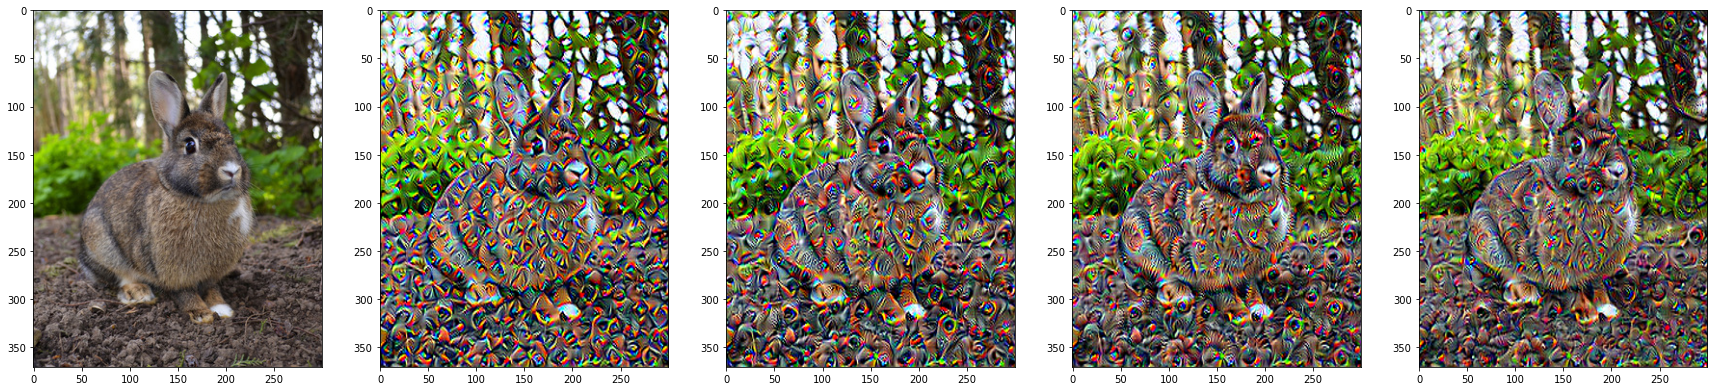

In [22]:
im = Image.open('bunny.jpg')
loi_samples = [6, 8, 12, 16]
n_samples = len(loi_samples)

f, ax = plt.subplots(1, n_samples + 1, figsize=(30, 20))
ax[0].imshow(im)

for i, loi in enumerate(loi_samples):
    trip = dream_deep(device,
                    im,
                    lr=0.1,
                    epochs=20,
                    loi=loi,
                    im_size=256)
    ax[i + 1].imshow(trip)